# PLAN

 - Диалоговый датасет
     - BANKING77
     - CLINC150
     - HWU64
     - https://github.com/google-research-datasets/dstc8-schema-guided-dialogue
 - Генератор (XLM-R)
     - придумать как генерировать токен на другом языке
     - применить к задачке
 - LABSE для полученных и исходных предложений
     - сделать кастомный класс лосса

Для XLM-R:

Занулить веса на выходе для всех языков кроме русского (пройтись по всем токенам и регулярочкой выявить те токены, которые относятся к русскому). Перед backward занулять градиенты по всем токенам не из русского, ибо торч не даст ставить requires_grad на отдельную часть тензора.

Как вариант - написать обертку над моделью, которая будет иметь меньший размер выходной головы, потом делать новый тензор с нулями на месте других языков и выходом модели для русского.

In [1]:
import json
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch

import sys

sns.set(style='darkgrid', rc={'figure.figsize': (16, 9)})
sys.path.append('..')

In [10]:
with open('../data/dstc_utterances.json') as f:
    data = json.load(f)

texts, intents = zip(*((elem['text'], elem['intent']) for elem in data))

len(texts), len(np.unique(intents))

(61767, 46)

In [11]:
lens = [len(text) for text in texts]

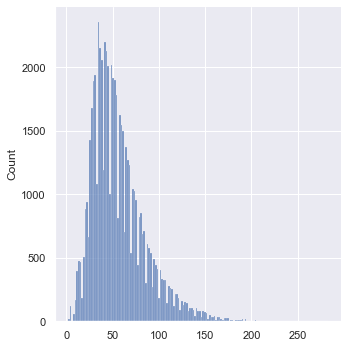

In [16]:
sns.displot(lens)
plt.show()

In [2]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

model_name = 'xlm-roberta-base'

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForMaskedLM.from_pretrained(model_name)

In [21]:
model.roberta.embeddings.word_embeddings.weight

Parameter containing:
tensor([[ 0.1630,  0.1508,  0.1604,  ...,  0.1351,  0.1860,  0.0673],
        [-0.0073,  0.0048, -0.0078,  ...,  0.0078,  0.0041, -0.0078],
        [ 0.2046,  0.2549,  0.1329,  ...,  0.1738,  0.0246,  0.2510],
        ...,
        [ 0.3828, -0.4441,  0.1398,  ...,  0.2268,  0.0560,  0.1038],
        [ 0.0205, -0.1243,  0.0191,  ..., -0.0143,  0.0376, -0.1144],
        [ 0.1009,  0.0588,  0.0551,  ...,  0.1232, -0.0064,  0.1216]],
       requires_grad=True)

In [25]:
c = torch.stack((a, a))

In [32]:
emb = model.roberta.embeddings.word_embeddings.weight[c]

In [33]:
c.shape, emb.shape

(torch.Size([2, 100]), torch.Size([2, 100, 768]))

In [35]:
emb[c == 0] = 0

In [36]:
emb

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0908, -0.1393, -0.0595,  ...,  0.1466, -0.0898,  0.2864],
         [ 0.0435,  0.4148, -0.3076,  ...,  0.3025,  0.0803, -0.0367],
         ...,
         [-0.0073,  0.0048, -0.0078,  ...,  0.0078,  0.0041, -0.0078],
         [-0.0073,  0.0048, -0.0078,  ...,  0.0078,  0.0041, -0.0078],
         [-0.0073,  0.0048, -0.0078,  ...,  0.0078,  0.0041, -0.0078]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0908, -0.1393, -0.0595,  ...,  0.1466, -0.0898,  0.2864],
         [ 0.0435,  0.4148, -0.3076,  ...,  0.3025,  0.0803, -0.0367],
         ...,
         [-0.0073,  0.0048, -0.0078,  ...,  0.0078,  0.0041, -0.0078],
         [-0.0073,  0.0048, -0.0078,  ...,  0.0078,  0.0041, -0.0078],
         [-0.0073,  0.0048, -0.0078,  ...,  0.0078,  0.0041, -0.0078]]],
       grad_fn=<IndexPutBackward>)

In [22]:
a = tokenizer.encode("I went fishing and I caught several big fish", return_tensors='pt', max_length=100, padding='max_length').flatten()

In [5]:
import regex

def is_cyrillic(s: str):
    return bool(regex.search(r'\p{IsCyrillic}', s))


russian_tokens_mask = np.zeros(model.lm_head.decoder.weight.shape[0])

for token in range(model.lm_head.decoder.weight.shape[0]):
    if is_cyrillic(tokenizer.decode([token])):
        russian_tokens_mask[token] = 1

In [6]:
russian_tokens_mask = russian_tokens_mask.astype(bool)

In [7]:
russian_tokens_mask.sum()

31671

In [8]:
with torch.no_grad():
    model.lm_head.decoder.weight[~russian_tokens_mask] = 0

In [95]:
sequence = f'I have a {tokenizer.mask_token}'

inputs = tokenizer.encode(sequence, return_tensors='pt')
mask_token_index = torch.where(inputs == tokenizer.mask_token_id)[1]

token_logits = model(inputs).logits
mask_token_logits = token_logits[0, mask_token_index, :]

tokenizer.decode([torch.argmax(mask_token_logits)])

'...'

In [100]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
import torch
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

sequence = f"I went fishing and I {tokenizer.mask_token} several big fish."
input = tokenizer.encode(sequence, return_tensors="pt")
mask_token_index = torch.where(input == tokenizer.mask_token_id)[1]
token_logits = model(input).logits
mask_token_logits = token_logits[0, mask_token_index, :]
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

/home/lesha/.local/lib/python3.8/site-packages/transformers/models/auto/modeling_auto.py:966: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [102]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
import torch
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

In [103]:
torch.save(model.state_dict(), '../models/xlm-roberta-base.pth')

In [101]:
for token in top_5_tokens:
    print(sequence.replace(tokenizer.mask_token, tokenizer.decode([token])))

I went fishing and I caught several big fish.
I went fishing and I saw several big fish.
I went fishing and I found several big fish.
I went fishing and I got several big fish.
I went fishing and I had several big fish.


In [77]:
token_logits

tensor([[[ 0.4143, -0.0156,  0.2747,  ...,  0.1248,  0.1586, -0.0836],
         [ 0.4143, -0.0156,  0.2747,  ...,  0.1248,  0.1586, -0.0836],
         [ 0.4143, -0.0156,  0.2747,  ...,  0.1248,  0.1586, -0.0836],
         ...,
         [ 0.4143, -0.0156,  0.2747,  ...,  0.1248,  0.1586, -0.0836],
         [ 0.4143, -0.0156,  0.2747,  ...,  0.1248,  0.1586, -0.0836],
         [ 0.4143, -0.0156,  0.2747,  ...,  0.1248,  0.1586, -0.0836]]],
       grad_fn=<AddBackward0>)

In [81]:
inputs = inputs.reshape(-1, 1)

In [88]:
torch.zeros(inputs.shape[0], 250002).scatter_(1, inputs, 1.0)[inputs.flatten() == tokenizer.mask_token_id]

tensor([[0., 0., 0.,  ..., 0., 0., 1.]])

In [87]:
[inputs.flatten() == tokenizer.mask_token_id]

[tensor([False, False, False, False,  True, False, False, False])]

In [31]:
one_hot.shape

torch.Size([1, 250002])

In [56]:
tensor = torch.LongTensor([1, 2, 3]).reshape(-1, 1)

y = torch.zeros(len(tensor), 250002).scatter_(1, tensor, 1.0) @ model.roberta.embeddings.word_embeddings.weight

In [12]:
embedding_output = one_hot @ model.roberta.embeddings.word_embeddings.weight

In [57]:
y.shape

torch.Size([3, 768])

In [49]:
y[tensor == 3, :]

IndexError: too many indices for tensor of dimension 2

In [52]:
y.shape, tensor.shape

(torch.Size([3, 768]), torch.Size([3, 1]))

In [60]:
y = torch.zeros(len(tensor), 250002).scatter_(1, tensor, 1.0)

In [66]:
y[tensor.flatten() == 3] = torch.nn.functional.gumbel_softmax(mask_token_logits, hard=True)

In [67]:
y

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<IndexPutBackward>)

In [45]:
y.unsqueeze(0).shape

torch.Size([1, 3, 768])

In [46]:
model.forward(inputs_embeds=y.unsqueeze(0))

MaskedLMOutput(loss=None, logits=tensor([[[ 0.4143, -0.0156,  0.2747,  ...,  0.1248,  0.1586, -0.0836],
         [ 0.4143, -0.0156,  0.2747,  ...,  0.1248,  0.1586, -0.0836],
         [ 0.4143, -0.0156,  0.2747,  ...,  0.1248,  0.1586, -0.0836]]],
       grad_fn=<AddBackward0>), hidden_states=None, attentions=None)

In [47]:
model.forward(input_ids=tensor)

MaskedLMOutput(loss=None, logits=tensor([[[ 0.4143, -0.0156,  0.2747,  ...,  0.1248,  0.1586, -0.0836]],

        [[ 0.4143, -0.0156,  0.2747,  ...,  0.1248,  0.1586, -0.0836]],

        [[ 0.4143, -0.0156,  0.2747,  ...,  0.1248,  0.1586, -0.0836]]],
       grad_fn=<AddBackward0>), hidden_states=None, attentions=None)

In [186]:
outputs = inputs.float()
outputs[inputs == tokenizer.mask_token_id] = torch.sum(torch.nn.functional.gumbel_softmax(mask_token_logits, hard=True) * torch.arange(0, mask_token_logits.shape[1]))

In [187]:
outputs

tensor([[  0.,  87., 765.,  10., 983.,   6.,   5.,   2.]],
       grad_fn=<IndexPutBackward>)

In [188]:
outputs2 = outputs.long()

In [197]:
outputs.grad_fn

In [198]:
outputs2.grad_fn = outputs.grad_fn

AttributeError: attribute 'grad_fn' of 'torch._C._TensorBase' objects is not writable

In [185]:
outputs2

In [166]:
inputs = tokenizer.encode(sequence, return_tensors='pt')
mask_token_index = torch.where(inputs == tokenizer.mask_token_id)[1]

In [169]:
inputs[inputs == tokenizer.mask_token_id] = torch.sum(torch.nn.functional.gumbel_softmax(mask_token_logits, hard=True) * torch.arange(0, mask_token_logits.shape[1]))

RuntimeError: Index put requires the source and destination dtypes match, got Long for the destination and Float for the source.

In [162]:
inputs

tensor([[0.0000e+00, 8.7000e+01, 7.6500e+02, 1.0000e+01, 2.0384e+05, 6.0000e+00,
         5.0000e+00, 2.0000e+00]], grad_fn=<IndexPutBackward>)

In [157]:
mask_token_index.item()

4

In [19]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel


class CustomLoss(nn.Module):
    """
    Custom loss counting similarity between target and output sentence
    """

    def __init__(self, device):
        super().__init__()

        self.model_name = 'sentence-transformers/xlm-r-100langs-bert-base-nli-mean-tokens'
        self.model = AutoModel.from_pretrained(self.model_name).to(device)
        self.model.eval()

    def forward(self, outputs, labels):
        outputs_1 = self.model(**outputs)
        outputs_2 = self.model(**labels)

        embeddings_1 = outputs_1.pooler_output
        embeddings_2 = outputs_2.pooler_output

        normalized_embeddings_1 = F.normalize(embeddings_1, p=2)
        normalized_embeddings_2 = F.normalize(embeddings_2, p=2)

        return normalized_embeddings_1 @ normalized_embeddings_2.transpose(0, 1)


In [20]:
model_name = 'sentence-transformers/xlm-r-100langs-bert-base-nli-mean-tokens'
model = AutoModel.from_pretrained(model_name)

In [21]:
model.config.to_json_file('../models/xmr-roberta-base-mean-tokens.json')

In [104]:
from transformers import XLMRobertaModel, PretrainedConfig

model = XLMRobertaModel(PretrainedConfig.from_json_file('../models/xlm-roberta-base-mean-tokens.json'))

In [105]:
model.load_state_dict(torch.load('../models/xlm-roberta-base-mean-tokens.pth'))

<All keys matched successfully>

In [106]:
model

XLMRobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(250002, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): 

In [81]:
loss = CustomLoss(torch.device('cuda:0'))

In [82]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

In [120]:
inputs = tokenizer.encode("I went fishing and I caught several big fish", return_tensors='pt')

model.embeddings(inputs)

tensor([[[-0.0416,  0.0110, -0.0000,  ...,  0.0000, -0.1096, -0.0141],
         [ 0.0631, -0.6998, -0.5704,  ..., -0.1152, -0.4210,  0.5102],
         [-0.1585,  0.0000, -0.7146,  ...,  0.6517,  0.3447, -0.1969],
         ...,
         [-0.0000, -0.1132, -0.4343,  ...,  1.0054, -0.0928, -0.0329],
         [ 0.1366,  0.8943,  0.0611,  ...,  0.0495, -0.3360, -0.6585],
         [ 0.0166,  0.1572,  0.0089,  ...,  0.0337,  0.0542, -0.1161]]],
       grad_fn=<MulBackward0>)

In [121]:
inputs = inputs.reshape(-1, 1)

tokens_one_hot = torch.zeros(inputs.shape[0], 250002).scatter_(
    1, inputs, 1.0
)

In [122]:
model.embeddings.forward(inputs_embeds=(tokens_one_hot @ model.embeddings.word_embeddings.weight).unsqueeze(0))

tensor([[[-0.0416,  0.0000, -0.0678,  ...,  0.0280, -0.1096, -0.0141],
         [ 0.0631, -0.6998, -0.5704,  ..., -0.1152, -0.4210,  0.5102],
         [-0.1585,  0.4480, -0.7146,  ...,  0.6517,  0.3447, -0.1969],
         ...,
         [-0.8030, -0.1132, -0.4343,  ...,  1.0054, -0.0928, -0.0329],
         [ 0.1366,  0.8943,  0.0611,  ...,  0.0000, -0.3360, -0.6585],
         [ 0.0166,  0.1572,  0.0089,  ...,  0.0337,  0.0542, -0.1161]]],
       grad_fn=<MulBackward0>)

In [124]:
torch.allclose(model.embeddings(inputs), model.embeddings.forward(inputs_embeds=(tokens_one_hot @ model.embeddings.word_embeddings.weight).unsqueeze(0)))

False

In [134]:
model.eval()

with torch.no_grad():
    inputs = tokenizer.encode("I went fishing and I caught several big fish", return_tensors='pt')
    
    x = model.embeddings(inputs)
    
    inputs = tokenizer.encode("I went fishing and I caught several big fish", return_tensors='pt').reshape(-1, 1)

    tokens_one_hot = torch.zeros(inputs.shape[0], 250002).scatter_(
        1, inputs, 1.0
    )
    
    y = model.embeddings.forward(inputs_embeds=(tokens_one_hot @ model.embeddings.word_embeddings.weight).unsqueeze(0))
    
    

In [135]:
x.shape

torch.Size([1, 12, 768])

In [136]:
y.shape

torch.Size([1, 12, 768])

In [137]:
torch.mean((x == y).float())

tensor(1.)